# Agentic Framework LangGraph Explained
I will be using this notebook to take notes on the [Agentic Framework LangGraph Explained](https://www.youtube.com/watch?v=1Q_MDOWaljk) video. I've already grasped the basics of nodes, edges, conditional edges and workflows, but I would also like to get a taste from another tutorial for a new point of view. It might help me answer questions that I never knew I had!

## State
The first we need to do is define the state. It is important to note that states are different from nodes.


In [1]:
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

from typing import Annotated
from typing_extensions import TypedDict

# TypedDict is used to create a dictionary with explicitly defined key-value types.
# Each state will essentially be repressented as a pre-defined dictionary
class State(TypedDict):
    # Annotated is a special type hinting feature that allows attaching metadata to type hints without altering the actual type
    # For example:
    # def process(x: Annotated[int, "Must be a positive integer"]):
    #   print(x)
    # Python ignores "Must be a positive integer" at runtime, but libraries (like pydantic, langgraph, etc.) can read this metadata.

    # The add_messages reducer function is used to append new messages to the list instead of overwriting it. 
    # By default, keys without a reducer annotation will overwrite previous values. 
    messages : Annotated[list, add_messages]

# Our graph will now store State class objects in each node
graph = StateGraph(State)

## Tools
Since we are building a ReAct agent, we are going to need tools. This is the default way of building tools using the @tool decorator.

In [2]:
from langchain_core.tools import tool

@tool
def get_weather(location : str) -> str:
    """
    Call this tool to get the current weather
    """
    if "ioannina" in location.lower():
        return "It's raining cats and dogs!"
    else:
        return "It's warm and sunny"

# Always save your tools in your toolkit!
tools = []
tools.append(get_weather)

## LLM with tools
Now we can initialize the LLM and bind it with our own toolkit.

In [3]:
from langchain_openai import ChatOpenAI

# Model init
import os
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=OPENAI_API_KEY, temperature=0)

# Bind with tool
llm_with_tools = llm.bind_tools(tools)

## Tool node
One of the most important features of a workflow is the tool node. This node contains all available tools that the model has access to.

In [4]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)
graph.add_node("tool_node", tool_node)

## Prompt Node
This is the node where we invoke the model. The model will then decide if it needs a tool or not.

In [5]:
def prompt_node(state : State) -> State:
    """
    Invokes the model to decided whether a tool needs to be called or not
    """
    chat_history = state["messages"]
    new_message = llm_with_tools.invoke(chat_history)
    # Don't forget to return a State. This State will be appended to the 'State History' thanks to 'add_messages'
    return {"messages" : [new_message]}

graph.add_node("prompt_node", prompt_node)

## Edges
Now we connect all the nodes together. Our entry point will be the prompt node. The prompt node will then decide whether we need to call a tool or not using a conditional edge. If the model needs no tool call, the workflow ends, Otherwise, we move onto the tool node, and then we move back to the prompt node

In [6]:
from typing import Literal

# Set entry point
graph.set_entry_point("prompt_node")

# This function strictly returns either one of these string values: 'tool_node' or '__end__'
def conditional_edge(state : State) -> Literal['tool_node', '__end__']:
    """
    Decides whether a tool should be called or not
    """
    # If the last message contained a tool call we need to route to the tool node
    chat_history = state["messages"]
    last_message = chat_history[-1]
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, the workflow ends
    else:
        return "__end__"
    
# Add conditional edge
graph.add_conditional_edges(
    'prompt_node',
    conditional_edge
)

# Add edge from tool to prompt node
graph.add_edge("tool_node", "prompt_node")

## Compile and visualization
After compiling, Python offers this really helpful library to visualize our graph

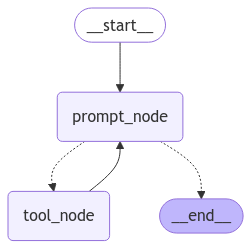

In [7]:
from IPython.display import Image, display
APP = graph.compile()
display(Image(APP.get_graph().draw_mermaid_png()))

## Invoke the APP
Finally, all we have to do is invoke the app with a HumanMessage. I also like adding a SystemMessage to my chat history.

In [11]:
from langchain_core.messages import HumanMessage, SystemMessage

chat_history = []
chat_history.append(SystemMessage(content="You are a helpful assistant that answers user questions regarding the weather. You use tools for that."))
chat_history.append(HumanMessage(content="What is the weather like in Ioannina, Greece?"))

output_state = APP.invoke({"messages" : chat_history})
content = output_state["messages"][-1].content
print(f"ChatGPT: {content}")

ChatGPT: The weather in Ioannina, Greece is currently very rainy.
